In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


In [ ]:
import pandas as pd

df = pd.read_pickle("merged_training.pkl")

In [ ]:
df

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [ ]:
from datasets import load_dataset



dataset = load_dataset('emotion')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']


In [ ]:
# Re-define the get_tweet function
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

# Re-define classes
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Create class mappings
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

# Function to convert label names to indices
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

print("Functions and mappings defined successfully!")
print(f"Classes: {classes}")
print(f"Class to index mapping: {class_to_index}")

Functions and mappings defined successfully!
Classes: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Class to index mapping: {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}


In [ ]:
tweets,labels=get_tweet(train)

In [ ]:
tweets[0],labels[0]

('i didnt feel humiliated', 0)

In [ ]:
#tokenization each word one number must be assigned so that it can be used in ml model in general every unique 1 token given but we can also adjust such that common words 1 token
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer=Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[0]])



[[2, 139, 3, 679]]

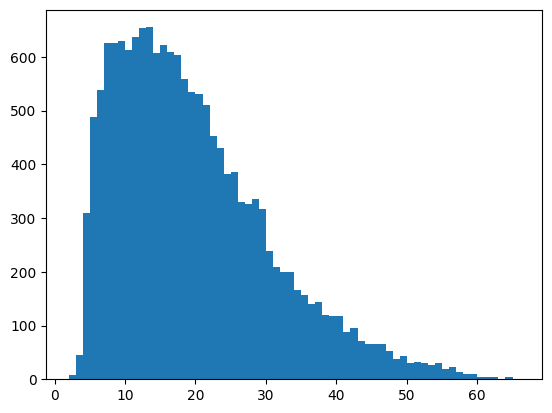

In [ ]:
lengths=[len(t.split(' ')) for t in tweets ]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()#showing the most common features


In [ ]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequence(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  paddes=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return paddes
#every input exactly same size every tweet will of length 50

In [ ]:
padded_train_seq=get_sequence(tokenizer,tweets)
padded_train_seq[0]


array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
#preparing the labels
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


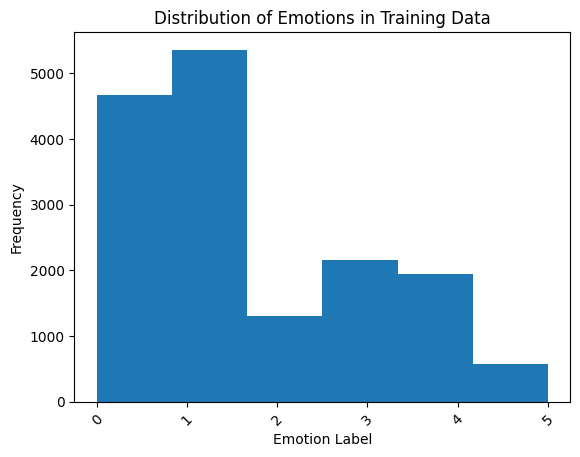

In [ ]:
# Fix: Use 'labels' (plural) and set bins to 6 (for 6 emotion classes)
plt.hist(labels, bins=6)
plt.xlabel('Emotion Label')
plt.ylabel('Frequency')
plt.title('Distribution of Emotions in Training Data')
plt.xticks(range(6), classes, rotation=45)
plt.show()

In [ ]:
# First, define the classes with emotion names
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Now create the mappings
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

print("class_to_index:", class_to_index)
print("index_to_class:", index_to_class)


class_to_index: {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
index_to_class: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [ ]:
names_to_ids=lambda labels:np.array([class_to_index.get(x)for x in labels])
train_labels=names_to_ids(labels)
print(train_labels[0])

0


In [ ]:
#model
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')


])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define classes as a list
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Prepare validation data
val_tweets, val_labels_raw = get_tweet(val)
val_seq = get_sequence(tokenizer, val_tweets)

# Labels from the 'emotion' dataset are already integers (0-5)
# So just convert to numpy array, no mapping needed
val_labels = np.array(val_labels_raw)

print(f"Validation tweets: {len(val_tweets)}")
print(f"Validation sequences shape: {val_seq.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Sample validation tweet: {val_tweets[0]}")
print(f"Sample validation label: {val_labels[0]} ({classes[val_labels[0]]})")

Validation tweets: 2000
Validation sequences shape: (2000, 50)
Validation labels shape: (2000,)
Sample validation tweet: im feeling quite sad and sorry for myself but ill snap out of it soon
Sample validation label: 0 (sadness)


In [ ]:
val_labels,val_tweets

(array([0, 0, 2, ..., 1, 1, 1]),
 ['im feeling quite sad and sorry for myself but ill snap out of it soon',
  'i feel like i am still looking at a blank canvas blank pieces of paper',
  'i feel like a faithful servant',
  'i am just feeling cranky and blue',
  'i can have for a treat or if i am feeling festive',
  'i start to feel more appreciative of what god has done for me',
  'i am feeling more confident that we will be able to take care of this baby',
  'i feel incredibly lucky just to be able to talk to her',
  'i feel less keen about the army every day',
  'i feel dirty and ashamed for saying that',
  'i feel bitchy but not defeated yet',
  'i was dribbling on mums coffee table looking out of the window and feeling very happy',
  'i woke up often got up around am feeling pukey radiation and groggy',
  'i was feeling sentimental',
  'i walked out of there an hour and fifteen minutes later feeling like i had been beaten with a stick and then placed on the rack and stretched',
  'i

In [ ]:
# For training data
tweets, labels_raw = get_tweet(train)
padded_train_seq = get_sequence(tokenizer, tweets)
train_labels = np.array(labels_raw)  # Just convert to array, labels are already integers

print(f"Training sequences shape: {padded_train_seq.shape}")
print(f"Training labels shape: {train_labels.shape}")

Training sequences shape: (16000, 50)
Training labels shape: (16000,)


In [ ]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 20
batch_size = 32

h = model.fit(
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.3797 - loss: 1.5433 - val_accuracy: 0.5805 - val_loss: 1.1366
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.6226 - loss: 0.9773 - val_accuracy: 0.7615 - val_loss: 0.7280
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8425 - loss: 0.4847 - val_accuracy: 0.8415 - val_loss: 0.4874
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.9186 - loss: 0.2618 - val_accuracy: 0.8705 - val_loss: 0.4121
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.9461 - loss: 0.1725 - val_accuracy: 0.8825 - val_loss: 0.3637
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.9595 - loss: 0.1381 - val_accuracy: 0.8870 - val_loss: 0.3789
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.9684 - loss: 0.1057 - val_accuracy: 0.8870 - val_loss: 0.4006
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.9733 - loss: 0.0882 - 

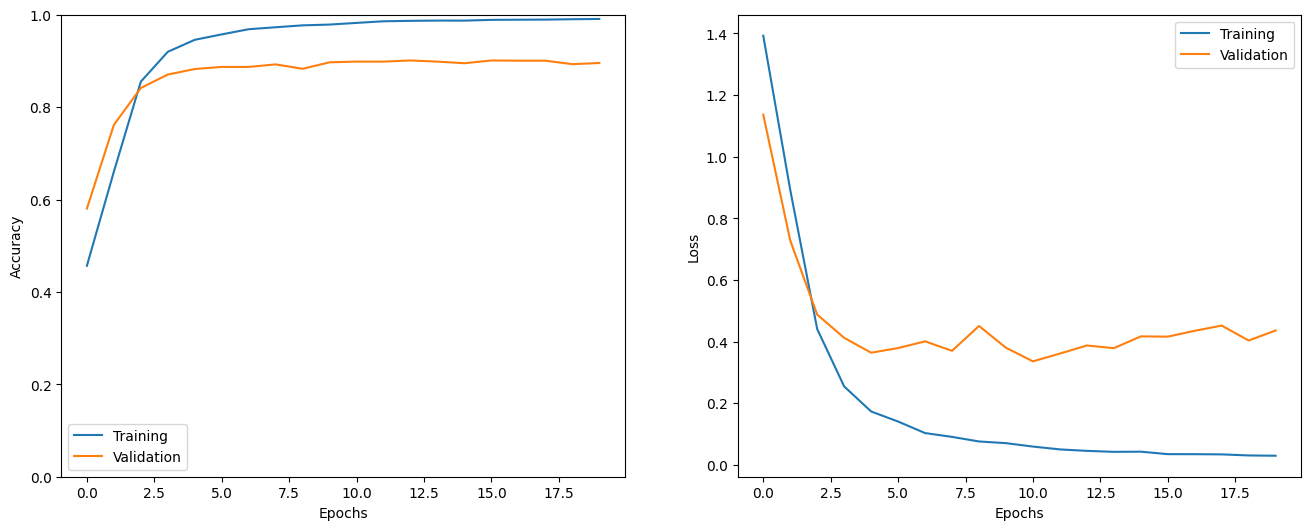

In [ ]:
# Show training history
show_history(h)

In [ ]:
# Prepare test data
test_tweets, test_labels_raw = get_tweet(test)
test_seq = get_sequence(tokenizer, test_tweets)
test_labels = np.array(test_labels_raw)

print(f"Test sequences shape: {test_seq.shape}")
print(f"Test labels shape: {test_labels.shape}")

Test sequences shape: (2000, 50)
Test labels shape: (2000,)


In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_seq, test_labels, verbose=1)
print(f'\n{"="*50}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')
print(f'{"="*50}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8917 - loss: 0.3964

Test Accuracy: 89.30%
Test Loss: 0.4223


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


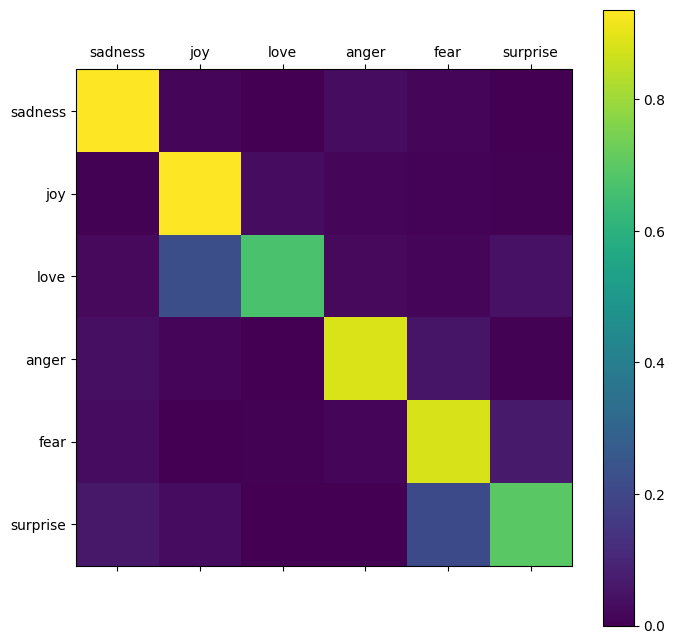

In [ ]:
# Make predictions
predictions = model.predict(test_seq)
predicted_labels = np.argmax(predictions, axis=1)

# Show confusion matrix
show_confusion_matrix(test_labels, predicted_labels, classes)

In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print("="*60)
print(classification_report(test_labels, predicted_labels, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

     sadness       0.95      0.93      0.94       581
         joy       0.93      0.94      0.93       695
        love       0.82      0.67      0.73       159
       anger       0.87      0.88      0.88       275
        fear       0.81      0.88      0.84       224
    surprise       0.62      0.70      0.66        66

    accuracy                           0.89      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
# Function to predict sentiment of new tweets
def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, truncating='post', padding='post', maxlen=maxlen)
    prediction = model.predict(padded, verbose=0)
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence

# Test with custom examples
sample_tweets = [
    "I am so happy today!",
    "This is terrible and makes me angry",
    "I'm feeling very sad right now",
    "I love spending time with my family",
    "That's really surprising!",
    "I'm scared about what might happen"
]

print("\n" + "="*60)
print("Sample Predictions:")
print("="*60)
for tweet in sample_tweets:
    sentiment, confidence = predict_sentiment(tweet)
    print(f"\nTweet: {tweet}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.4f})")


Sample Predictions:

Tweet: I am so happy today!
Predicted Sentiment: joy (Confidence: 0.9397)

Tweet: This is terrible and makes me angry
Predicted Sentiment: sadness (Confidence: 0.9952)

Tweet: I'm feeling very sad right now
Predicted Sentiment: sadness (Confidence: 0.9988)

Tweet: I love spending time with my family
Predicted Sentiment: joy (Confidence: 0.6774)

Tweet: That's really surprising!
Predicted Sentiment: joy (Confidence: 0.6145)

Tweet: I'm scared about what might happen
Predicted Sentiment: fear (Confidence: 0.9767)


In [ ]:
# Save the model
model.save('emotion_sentiment_model.h5')
print("Model saved as 'emotion_sentiment_model.h5'")

# Save tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved as 'tokenizer.pkl'")

Model saved as 'emotion_sentiment_model.h5'
Tokenizer saved as 'tokenizer.pkl'
